<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg">
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitskiy](https://yorko.github.io) (@yorko). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

## <center> Assignment 4. Sarcasm detection with logistic regression
    
We'll be using the dataset from the [paper](https://arxiv.org/abs/1704.05579) "A Large Self-Annotated Corpus for Sarcasm" with >1mln comments from Reddit, labeled as either sarcastic or not. A processed version can be found on Kaggle in a form of a [Kaggle Dataset](https://www.kaggle.com/danofer/sarcasm).

Sarcasm detection is easy. 
<img src="https://habrastorage.org/webt/1f/0d/ta/1f0dtavsd14ncf17gbsy1cvoga4.jpeg" />

In [1]:
!ls ../input/sarcasm/

test-balanced.csv    train-balanced-sarc.csv.gz
test-unbalanced.csv  train-balanced-sarcasm.csv


In [2]:
# some necessary imports
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
train_df = pd.read_csv('../input/sarcasm/train-balanced-sarcasm.csv')

In [4]:
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
label             1010826 non-null int64
comment           1010773 non-null object
author            1010826 non-null object
subreddit         1010826 non-null object
score             1010826 non-null int64
ups               1010826 non-null int64
downs             1010826 non-null int64
date              1010826 non-null object
created_utc       1010826 non-null object
parent_comment    1010826 non-null object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


Some comments are missing, so we drop the corresponding rows.

In [6]:
train_df.dropna(subset=['comment'], inplace=True)

We notice that the dataset is indeed balanced

In [7]:
train_df['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

We split data into training and validation parts.

In [8]:
train_texts, valid_texts, y_train, y_valid = train_test_split(train_df['comment'], train_df['label'], random_state=17)

## Tasks:
1. Analyze the dataset, make some plots. This [Kernel](https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-qiqc) might serve as an example
2. Build a Tf-Idf + logistic regression pipeline to predict sarcasm (`label`) based on the text of a comment on Reddit (`comment`).
3. Plot the words/bigrams which a most predictive of sarcasm (you can use [eli5](https://github.com/TeamHG-Memex/eli5) for that)
4. (optionally) add subreddits as new features to improve model performance. Apply here the Bag of Words approach, i.e. treat each subreddit as a new feature.

## Links:
  - Machine learning library [Scikit-learn](https://scikit-learn.org/stable/index.html) (a.k.a. sklearn)
  - Kernels on [logistic regression](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-2-classification) and its applications to [text classification](https://www.kaggle.com/kashnitsky/topic-4-linear-models-part-4-more-of-logit), also a [Kernel](https://www.kaggle.com/kashnitsky/topic-6-feature-engineering-and-feature-selection) on feature engineering and feature selection
  - [Kaggle Kernel](https://www.kaggle.com/abhishek/approaching-almost-any-nlp-problem-on-kaggle) "Approaching (Almost) Any NLP Problem on Kaggle"
  - [ELI5](https://github.com/TeamHG-Memex/eli5) to explain model predictions

Distribution of lengths for sarcastic and normal comments is almost the same:

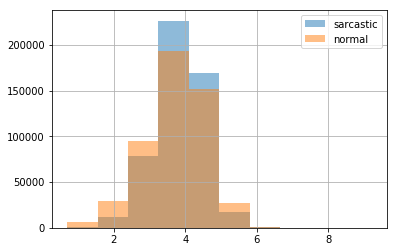

In [9]:
train_df[train_df['label'] == 1]['comment'].str.len().apply(np.log1p).hist(label='sarcastic', alpha=.5)
train_df[train_df['label'] == 0]['comment'].str.len().apply(np.log1p).hist(label='normal', alpha=.5)
plt.legend();

Nothing interesting for same authors

In [27]:
sub_df = train_df.groupby('author')['label'].agg([np.size, np.mean])
sub_df[sub_df['size'] > 100].sort_values(by='mean').head(10)

,size,mean
author,,
radpandaparty,104,0.490385
indoninja,106,0.490566
ward0630,101,0.495050
fitzroy95,111,0.495495
Yah-luna-tic,113,0.495575
iam4real,123,0.495935
Mad_Hatter_Bot,131,0.496183
ukulelej,137,0.496350
FNAFfan69,137,0.496350


Let's consider subreddits

In [32]:
sub_df = train_df.groupby('subreddit')['label'].agg([np.size, np.mean])
print(sub_df[sub_df['size'] > 1000].sort_values(by='mean').head(10))
print(sub_df[sub_df['size'] > 1000].sort_values(by='mean', ascending=False).head(10))

                     size      mean
subreddit                          
Games                1341  0.227442
4chan                1074  0.245810
aww                  2493  0.315684
science              1126  0.377442
BlackPeopleTwitter   1831  0.379574
Jokes                1378  0.381713
fantasyfootball      2274  0.386104
AskReddit           65674  0.401453
anime                1690  0.403550
gifs                 5267  0.411620
                  size      mean
subreddit                       
creepyPMs         5466  0.784303
MensRights        3355  0.680775
ShitRedditSays    1284  0.661994
worldnews        26376  0.642516
Libertarian       2562  0.640125
atheism           7377  0.639555
Conservative      1881  0.639553
TwoXChromosomes   1560  0.632692
fatlogic          2356  0.623090
facepalm          1268  0.617508


Really nice for some sub_reddits!

Training the model